In [1]:
!gdown 1jj9rBeApKyCUwuKb13GNwHOyWES0c8wO
!unzip data.zip

Downloading...
From: https://drive.google.com/uc?id=1jj9rBeApKyCUwuKb13GNwHOyWES0c8wO
To: /content/data.zip
100% 22.2M/22.2M [00:00<00:00, 178MB/s]
Archive:  data.zip
   creating: data/
  inflating: data/holidays_events.csv  
  inflating: data/oil.csv            
  inflating: data/sample_submission.csv  
  inflating: data/stores.csv         
  inflating: data/test.csv           
  inflating: data/train.csv          
  inflating: data/transactions.csv   


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
        
from scipy.stats import skew,norm,zscore
from scipy.signal import periodogram

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import gc
gc.enable() 

In [3]:
import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/transactions.csv
./data/oil.csv
./data/train.csv
./data/stores.csv
./data/holidays_events.csv
./data/sample_submission.csv
./data/test.csv


In [4]:
warnings.filterwarnings('ignore')

In [5]:
sns.set_theme()

# Importing the dataset

In [6]:
orig_holidays_events = pd.read_csv("./data/holidays_events.csv", parse_dates=['date'])
orig_oil = pd.read_csv("./data/oil.csv", parse_dates=['date'])
orig_stores = pd.read_csv("./data/stores.csv")
orig_transactions = pd.read_csv("./data/transactions.csv", parse_dates=['date'])

In [7]:
orig_test = pd.read_csv("./data/test.csv", parse_dates=['date'])
orig_train = pd.read_csv("./data/train.csv", parse_dates=['date'])

In [8]:
orig_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [9]:
orig_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [10]:
orig_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [11]:
orig_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [12]:
orig_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [13]:
orig_train.sample(10)

,id,date,store_nbr,family,sales,onpromotion
761651,761651,2014-03-05,3,FROZEN FOODS,425.689,0
1999927,1999927,2016-01-31,23,POULTRY,380.945,0
1873790,1873790,2015-11-20,34,HOME APPLIANCES,0.000,0
1264382,1264382,2014-12-12,35,LAWN AND GARDEN,0.000,0
2770860,2770860,2017-04-08,54,HOME AND KITCHEN I,41.000,0
1290244,1290244,2014-12-28,11,EGGS,190.000,0
1093729,1093729,2014-09-07,47,EGGS,649.000,0
2252082,2252082,2016-06-20,48,PRODUCE,1732.039,0
387829,387829,2013-08-06,40,GROCERY II,5.000,0
576903,576903,2013-11-20,45,PRODUCE,6.000,0


In [14]:
orig_test.sample(10)

,id,date,store_nbr,family,onpromotion
8302,3009190,2017-08-20,41,LADIESWEAR,0
12154,3013042,2017-08-22,5,EGGS,0
27524,3028412,2017-08-31,31,BEAUTY,0
21094,3021982,2017-08-27,50,CLEANING,14
13094,3013982,2017-08-23,26,PET SUPPLIES,0
11749,3012637,2017-08-22,39,BABY CARE,0
19694,3020582,2017-08-27,11,PET SUPPLIES,0
1610,3002498,2017-08-16,53,PET SUPPLIES,0
9953,3010841,2017-08-21,38,LAWN AND GARDEN,0
22114,3023002,2017-08-28,3,BOOKS,0


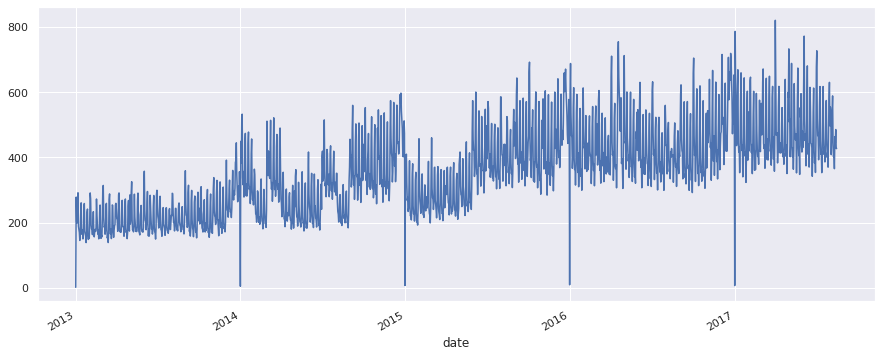

In [15]:
fig = plt.figure(figsize=(15,6))
orig_train.groupby(by='date')['sales'].mean().plot()

# Setting main dates

In [16]:
date = {}

In [17]:
date['date_start_train'] = '2013-01-01'
date['date_end_train'] = '2017-08-15'
date['date_start_test'] = '2017-08-16'
date['date_end_test'] = '2017-08-31'
date['date_start_fore'] = '2016-06-01'

In [18]:

diff_train = (pd.Timestamp(date['date_end_train']) - pd.Timestamp(date['date_start_fore'])).days
diff_test = (pd.Timestamp(date['date_end_test']) - pd.Timestamp(date['date_start_fore'])).days

# Zero

In [19]:
print(orig_train.shape)
orig_train = orig_train[~((orig_train.store_nbr == 52) & (orig_train.date < "2017-04-20"))]
orig_train = orig_train[~((orig_train.store_nbr == 22) & (orig_train.date < "2015-10-09"))]
orig_train = orig_train[~((orig_train.store_nbr == 42) & (orig_train.date < "2015-08-21"))]
orig_train = orig_train[~((orig_train.store_nbr == 21) & (orig_train.date < "2015-07-24"))]
orig_train = orig_train[~((orig_train.store_nbr == 29) & (orig_train.date < "2015-03-20"))]
orig_train = orig_train[~((orig_train.store_nbr == 20) & (orig_train.date < "2015-02-13"))]
orig_train = orig_train[~((orig_train.store_nbr == 53) & (orig_train.date < "2014-05-29"))]
orig_train = orig_train[~((orig_train.store_nbr == 36) & (orig_train.date < "2013-05-09"))]
orig_train.shape

(3000888, 6)


(2780316, 6)

In [20]:
c = orig_train.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
c = c[c.sales == 0]
c

,store_nbr,family,sales
1,1,BABY CARE,0.0
397,13,BABY CARE,0.0
727,23,BABY CARE,0.0
1420,44,BABY CARE,0.0
1453,45,BABY CARE,0.0
1486,46,BABY CARE,0.0
1519,47,BABY CARE,0.0
1552,48,BABY CARE,0.0
1585,49,BABY CARE,0.0
1618,50,BABY CARE,0.0


In [21]:
print(orig_train.shape)
# Anti Join
outer_join = orig_train.merge(c[c.sales == 0].drop("sales",axis = 1), how = 'outer', indicator = True)
orig_train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
del outer_join
gc.collect()
orig_train.shape

(2780316, 6)


(2698648, 6)

In [22]:
zero_prediction = []
for i in range(0,len(c)):
    zero_prediction.append(
        pd.DataFrame({
            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr":c.store_nbr.iloc[i],
            "family":c.family.iloc[i],
            "sales":0
        })
    )
zero_prediction = pd.concat(zero_prediction)
del c
gc.collect()
zero_prediction

,date,store_nbr,family,sales
0,2017-08-16,1,BABY CARE,0
1,2017-08-17,1,BABY CARE,0
2,2017-08-18,1,BABY CARE,0
3,2017-08-19,1,BABY CARE,0
4,2017-08-20,1,BABY CARE,0
...,...,...,...,...
11,2017-08-27,54,LAWN AND GARDEN,0
12,2017-08-28,54,LAWN AND GARDEN,0
13,2017-08-29,54,LAWN AND GARDEN,0
14,2017-08-30,54,LAWN AND GARDEN,0


In [23]:
zero_prediction.to_csv("zero.csv",index=False)

In [24]:
zero_prediction = pd.read_csv("zero.csv", parse_dates=['date'])

In [25]:
zero_prediction = zero_prediction.merge(orig_test, on=['date', 'store_nbr', 'family'])
zero_prediction

,date,store_nbr,family,sales,id,onpromotion
0,2017-08-16,1,BABY CARE,0,3000889,0
1,2017-08-17,1,BABY CARE,0,3002671,0
2,2017-08-18,1,BABY CARE,0,3004453,0
3,2017-08-19,1,BABY CARE,0,3006235,0
4,2017-08-20,1,BABY CARE,0,3008017,0
...,...,...,...,...,...,...
843,2017-08-27,54,LAWN AND GARDEN,0,3022127,0
844,2017-08-28,54,LAWN AND GARDEN,0,3023909,0
845,2017-08-29,54,LAWN AND GARDEN,0,3025691,0
846,2017-08-30,54,LAWN AND GARDEN,0,3027473,0


In [26]:
zero_prediction.to_csv("zero.csv",index=False)

# Stores

In [19]:
orig_stores.sample(10)

,store_nbr,city,state,type,cluster
31,32,Guayaquil,Guayas,C,3
24,25,Salinas,Santa Elena,D,1
23,24,Guayaquil,Guayas,D,1
8,9,Quito,Pichincha,B,6
27,28,Guayaquil,Guayas,E,10
12,13,Latacunga,Cotopaxi,C,15
37,38,Loja,Loja,D,4
13,14,Riobamba,Chimborazo,C,7
49,50,Ambato,Tungurahua,A,14
2,3,Quito,Pichincha,D,8


In [20]:
fig, axes = plt.subplots(54, 1, figsize=(15, 54*3))

for ax, i in zip(axes.flat, np.arange(0,54,1)):
    sns.lineplot(ax=axes[i], x=orig_train[orig_train.store_nbr==(i+1)].groupby(by='date')['sales'].mean().reset_index().date.values, y=orig_train[orig_train.store_nbr==(i+1)].groupby(by='date')['sales'].mean())
    ax.set_title(f'store_n_{i}') 
    
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [21]:
orig_stores.groupby(by=['city']).store_nbr.nunique().sort_values(ascending=False)
#plot số lượng cửa hàng của thành phố

city
Quito            18
Guayaquil         8
Santo Domingo     3
Cuenca            3
Manta             2
Machala           2
Latacunga         2
Ambato            2
Guaranda          1
Ibarra            1
Esmeraldas        1
Babahoyo          1
Loja              1
El Carmen         1
Daule             1
Playas            1
Puyo              1
Quevedo           1
Cayambe           1
Riobamba          1
Salinas           1
Libertad          1
Name: store_nbr, dtype: int64

In [22]:
def store_func (orig_df):
    
    df = orig_df.copy()
    
    # Adding features to orig_stores
    df['uniquestore'] = df.city.apply(lambda x: 0 if x in ['Quito', 'Guayaquil', 'Santo Domingo', 'Cuenca', 'Manta', 'Machala', 'Latacunga', 'Ambato'] else 1)
    df['newstore'] = df.store_nbr.apply(lambda x: 1 if x in [19, 20, 21, 28, 35, 41, 51, 52] else 0)
        
    # Merging orig_stores, orig_test and orig_train
    df = pd.concat([orig_train, orig_test], axis=0).merge(df, on=['store_nbr'], how='left')
    df = df.rename(columns={'type' : 'store'}) 

    return df

In [23]:
final_df = store_func(orig_stores)
final_df

,id,date,store_nbr,family,sales,onpromotion,city,state,store,cluster,uniquestore,newstore
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,0,0
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,0,0
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,0,0
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,0,0


# Events

In [24]:
orig_holidays_events.sample(10)

,date,type,locale,locale_name,description,transferred
86,2013-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False
129,2014-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
159,2015-01-01,Holiday,National,Ecuador,Primer dia del ano,False
127,2014-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False
252,2016-05-14,Event,National,Ecuador,Terremoto Manabi+28,False
37,2012-12-25,Holiday,National,Ecuador,Navidad,False
311,2017-05-14,Event,National,Ecuador,Dia de la Madre,False
81,2013-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
316,2017-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
102,2014-05-10,Additional,National,Ecuador,Dia de la Madre-1,False


In [25]:
orig_holidays_events.query("type=='Event'").description.value_counts()

Dia de la Madre                                    5
Mundial de futbol Brasil: Octavos de Final         4
Black Friday                                       3
Cyber Monday                                       3
Mundial de futbol Brasil: Cuartos de Final         2
Mundial de futbol Brasil: Semifinales              2
Terremoto Manabi+21                                1
Terremoto Manabi+14                                1
Terremoto Manabi+15                                1
Terremoto Manabi+16                                1
Terremoto Manabi+17                                1
Terremoto Manabi+18                                1
Terremoto Manabi+19                                1
Terremoto Manabi+20                                1
Terremoto Manabi+24                                1
Terremoto Manabi+22                                1
Terremoto Manabi+23                                1
Terremoto Manabi+12                                1
Terremoto Manabi+25                           

In [26]:
orig_holidays_events[orig_holidays_events[['date', 'locale_name']].duplicated()]

,date,type,locale,locale_name,description,transferred
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False
157,2014-12-26,Additional,National,Ecuador,Navidad+1,False
236,2016-05-01,Event,National,Ecuador,Terremoto Manabi+15,False
243,2016-05-07,Event,National,Ecuador,Terremoto Manabi+21,False
245,2016-05-08,Event,National,Ecuador,Dia de la Madre,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False


In [27]:
orig_holidays_events.query("date in ('2012-12-24', '2012-12-31', '2014-12-26', '2016-05-01', '2016-05-07', '2016-05-08', '2016-07-24')")

,date,type,locale,locale_name,description,transferred
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
157,2014-12-26,Additional,National,Ecuador,Navidad+1,False
235,2016-05-01,Holiday,National,Ecuador,Dia del Trabajo,False
236,2016-05-01,Event,National,Ecuador,Terremoto Manabi+15,False
242,2016-05-07,Additional,National,Ecuador,Dia de la Madre-1,False
243,2016-05-07,Event,National,Ecuador,Terremoto Manabi+21,False


In [28]:
orig_holidays_events.description[orig_holidays_events.description.str.match(r'.*ster.*')]

Series([], Name: description, dtype: object)

In [29]:
orig_train.groupby(by=['store_nbr','date'])['sales'].mean().reset_index().head()

,store_nbr,date,sales
0,1,2013-01-01,0.000000
1,1,2013-01-02,224.762061
2,1,2013-01-03,177.977091
3,1,2013-01-04,179.390273
4,1,2013-01-05,191.478334


In [30]:
orig_train.groupby(by=['store_nbr','date'])['sales'].mean().reset_index().query("date.dt.month==1 and date.dt.day==1").sample(10)

,store_nbr,date,sales
31769,19,2017-01-01,0.0
19981,12,2017-01-01,0.0
28036,17,2016-01-01,0.0
80605,48,2017-01-01,0.0
40189,24,2017-01-01,0.0
67360,41,2013-01-01,0.0
52568,32,2014-01-01,0.0
76872,46,2016-01-01,0.0
14564,9,2016-01-01,0.0
55572,34,2013-01-01,0.0


In [31]:
orig_holidays_events.query("transferred==True")

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


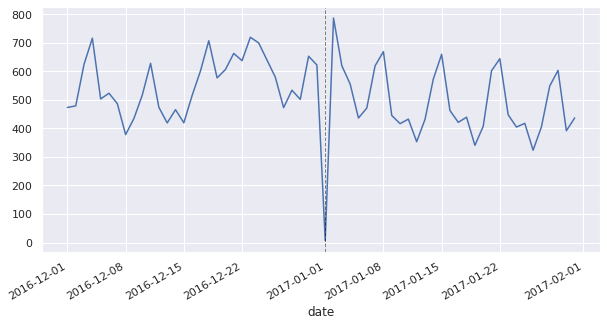

In [32]:
fig = plt.figure(figsize=(10,5))
orig_train.query("(date.dt.year==2017 and date.dt.month==1) or (date.dt.year==2016 and date.dt.month==12)").groupby(by='date')['sales'].mean().plot()
plt.axvline(x=pd.Timestamp('2017-01-01'), color='black', linestyle='--', linewidth=1, alpha=0.5)

In [33]:
orig_holidays_events.query("date.dt.month==1 and date.dt.day==1")

,date,type,locale,locale_name,description,transferred
41,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
92,2014-01-01,Holiday,National,Ecuador,Primer dia del ano,False
159,2015-01-01,Holiday,National,Ecuador,Primer dia del ano,False
211,2016-01-01,Holiday,National,Ecuador,Primer dia del ano,False
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True


In [34]:
def holiday_func (orig_df):
    
    df = orig_df.copy()
    
    # Non-transferred events
    df.loc[297, 'transferred'] = df.loc[297, 'transferred'] = False
    df = df.query("transferred!=True")
    
    # Removing duplicates
    df = df.drop(index=orig_holidays_events[orig_holidays_events[['date', 'locale_name']].duplicated()].index.values)

    # Adding event type
    df.loc[df.type=='Event', 'type'] = df.description.apply(lambda x: x[0:7])
     
    # Merging orig_holidays_events and final_df
    nat_df = df.query("locale=='National'")
    loc_df = df.query("locale=='Local'")
    reg_df = df.query("locale=='Regional'")
    
    df = final_df.merge(nat_df, left_on=['date'], right_on=['date'], how='left')
    df = df.merge(loc_df, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
    df = df.merge(reg_df, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')
   
    # Adding New Year
    df['firstday'] = df.description_x.apply(lambda x: 1 if x=='Primer dia del ano' else 0)

    # Matching event and store
    df = df.drop(columns=['locale_x', 'locale_name_x', 'description_x', 'transferred_x',
                          'locale_y', 'locale_name_y', 'description_y', 'transferred_y',
                          'locale', 'locale_name', 'description', 'transferred'])
    df.loc[~df.type_x.isnull(), 'event_type'] = df.type_x.apply(lambda x: x)
    df.loc[~df.type_y.isnull(), 'event_type'] = df.type_y.apply(lambda x: x)
    df.loc[~df.type.isnull(), 'event_type'] = df.type.apply(lambda x: x)
    df.loc[df.event_type.isnull(), 'event_type'] = df.event_type.apply(lambda x: 'norm')
    df = df.drop(columns=['type_x', 'type_y', 'type'])

    df['isevent'] = df.event_type.apply(lambda x: 'y' if x!='norm' else 'n')

    # Adding Easter
    df.loc[df.date.isin(['2017-04-16', '2016-03-27', '2015-04-05', '2014-04-20', '2013-03-31']), 'isevent'] = df.isevent.apply(lambda x: 'y')
    df.loc[df.date.isin(['2017-04-16', '2016-03-27', '2015-04-05', '2014-04-20', '2013-03-31']), 'event_type'] = df.event_type.apply(lambda x: 'Holiday')

    # Adding closure days
    df['isclosed'] = df.groupby(by=['date', 'store_nbr'])['sales'].transform(lambda x: 1 if x.sum()==0 else 0)    
    df.loc[(df.date.dt.year==2017) & (df.date.dt.month==8) & (df.date.dt.day>=16) , 'isclosed'] = df.isclosed.apply(lambda x: 0)    
    df.loc[df.date.isin(['2017-01-01']), 'isevent'] = df.isevent.apply(lambda x: 'n')
  
    return df

In [35]:
final_df = holiday_func(orig_holidays_events)

# Oil

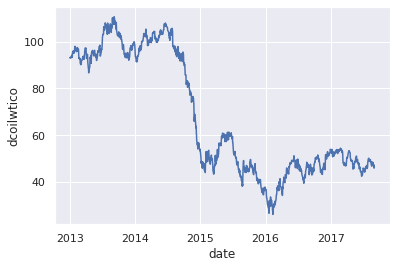

In [36]:
sns.lineplot(y=orig_oil.dcoilwtico, x=orig_oil.date)

In [37]:
orig_oil.set_index('date').resample("D").mean().isnull().sum()

dcoilwtico    529
dtype: int64

In [38]:
def oil_func (orig_df):
    
    df = orig_df.copy()
    
    # Adding missing values
    df = df.set_index('date').resample("D").mean().interpolate(method ='linear',limit_direction='backward').reset_index()
    
    # Adding new features
    df['lagoil_1_dcoilwtico'] = df['dcoilwtico'].shift(1)
    df['lagoil_2_dcoilwtico'] = df['dcoilwtico'].shift(2)
    df['lagoil_3_dcoilwtico'] = df['dcoilwtico'].shift(3)
    df['lagoil_4_dcoilwtico'] = df['dcoilwtico'].shift(4)
    df['oil_week_avg'] = df['dcoilwtico'].rolling(7).mean()
    df['oil_month_avg'] = df['dcoilwtico'].rolling(30).mean()
    df.dropna(inplace = True)
    
    # Merging orig_oil and final_df
    df = final_df.merge(df, on=['date'], how='left')
    
    return df

In [39]:
final_df = oil_func(orig_oil)

# Transactions

In [40]:
orig_transactions.sample(10)

,date,store_nbr,transactions
77035,2017-04-18,26,432
70768,2016-12-19,14,1611
47986,2015-10-08,47,3185
44017,2015-07-24,1,1820
20097,2014-03-10,45,3260
16802,2013-12-29,40,982
4834,2013-04-17,4,1511
6544,2013-05-23,49,1768
13345,2013-10-16,10,1028
53668,2016-01-28,8,2394


In [41]:
def transactions_func (orig_df):
    
    df = orig_df.copy()
    
    # Merging orig_transactions and final_df
    df = final_df.merge(df, on=['date', 'store_nbr'], how='left')
    
    # Filling missing values
    df.loc[(df.transactions.isnull()) & (df.isclosed==1), 'transactions'] = df.transactions.apply(lambda x: 0)
    group_df = df.groupby(by=['store_nbr', 'date']).transactions.first().reset_index()
    group_df['avg_tra'] = group_df.transactions.rolling(15, min_periods=10).mean()
    group_df.drop(columns='transactions', inplace=True)
    df = df.merge(group_df, on=['date', 'store_nbr'], how='left')
    df.loc[(df.transactions.isnull()) & (df.isclosed==0), 'transactions'] = df.avg_tra
    df.drop(columns='avg_tra', inplace=True)
    df.loc[(df.date.dt.year==2017) & (df.date.dt.month==8) & (df.date.dt.day>=16) , 'transactions'] = df.transactions.apply(lambda x: None)    

    df['tot_store_day_onprom'] = df.groupby(by=['date', 'store_nbr']).onpromotion.transform(lambda x: x.sum())

    return df

In [42]:
final_df = transactions_func(orig_transactions)

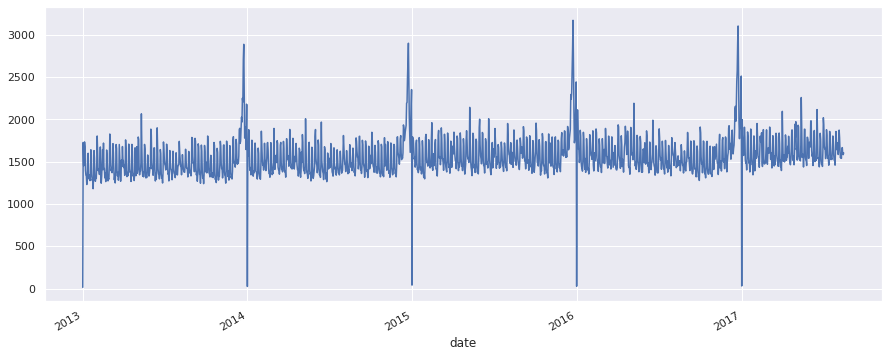

In [43]:
fig = plt.figure(figsize=(15,6))
final_df.groupby(by='date')['transactions'].mean().plot()

In [44]:
del orig_train
del orig_test
del orig_stores
del orig_holidays_events
del orig_oil
del orig_transactions

# Final dataframe

In [45]:
final_df.sample(10)

,id,date,store_nbr,family,sales,onpromotion,city,state,store,cluster,...,isclosed,dcoilwtico,lagoil_1_dcoilwtico,lagoil_2_dcoilwtico,lagoil_3_dcoilwtico,lagoil_4_dcoilwtico,oil_week_avg,oil_month_avg,transactions,tot_store_day_onprom
1259268,1259268,2014-12-09,41,LINGERIE,13.000,0,Machala,El Oro,D,4,...,0,63.74,63.130000,64.050000,64.970000,65.890000,65.115714,71.637333,999.0,30
2989048,2989048,2017-08-09,27,CLEANING,707.000,11,Daule,Guayas,D,1,...,0,49.59,49.070000,49.370000,49.436667,49.503333,49.367143,47.851000,1587.0,335
2764973,2764973,2017-04-05,4,BEAUTY,4.000,1,Quito,Pichincha,D,9,...,0,51.14,50.990000,50.250000,50.346667,50.443333,50.572857,48.706333,1489.0,312
2437808,2437808,2016-10-03,1,SEAFOOD,25.098,0,Quito,Pichincha,D,13,...,0,48.80,48.440000,48.080000,47.720000,47.720000,47.497143,45.481500,1794.0,140
748372,748372,2014-02-25,7,SCHOOL AND OFFICE SUPPLIES,0.000,0,Quito,Pichincha,D,8,...,0,102.20,103.170000,102.956667,102.743333,102.530000,102.894286,99.918500,1818.0,0
499598,499598,2013-10-08,27,FROZEN FOODS,93.000,0,Daule,Guayas,D,1,...,0,103.54,103.070000,103.323333,103.576667,103.830000,103.540000,104.865667,1110.0,0
1090330,1090330,2014-09-05,51,EGGS,326.000,28,Guayaquil,Guayas,A,17,...,0,93.32,94.510000,95.500000,92.920000,94.155000,94.631429,95.924333,1723.0,178
2798495,2798495,2017-04-24,3,PREPARED FOODS,243.765,0,Quito,Pichincha,D,8,...,0,48.90,49.146667,49.393333,49.640000,50.260000,50.041429,50.986611,2754.0,264
536851,536851,2013-10-29,22,CLEANING,0.000,0,Puyo,Pastaza,C,7,...,1,98.29,98.740000,98.293333,97.846667,97.400000,97.731429,100.982000,0.0,0
288153,288153,2013-06-11,43,PRODUCE,0.000,0,Esmeraldas,Esmeraldas,E,10,...,0,95.50,95.820000,95.916667,96.013333,96.110000,95.390000,94.496167,1066.0,0


In [46]:
final_df = final_df.set_index('date').loc[date['date_start_fore']:,:]

In [47]:
final_df.isnull().sum()

id                          0
store_nbr                   0
family                      0
sales                   28512
onpromotion                 0
city                        0
state                       0
store                       0
cluster                     0
uniquestore                 0
newstore                    0
firstday                    0
event_type                  0
isevent                     0
isclosed                    0
dcoilwtico                  0
lagoil_1_dcoilwtico         0
lagoil_2_dcoilwtico         0
lagoil_3_dcoilwtico         0
lagoil_4_dcoilwtico         0
oil_week_avg                0
oil_month_avg               0
transactions            28512
tot_store_day_onprom        0
dtype: int64

In [48]:
final_df.groupby(by=['city']).sales.sum().sort_values(ascending=False)

city
Quito            1.850662e+08
Guayaquil        4.155775e+07
Cuenca           1.876670e+07
Ambato           1.281856e+07
Santo Domingo    1.269997e+07
Machala          1.196877e+07
Cayambe          8.777466e+06
Manta            8.358425e+06
Daule            6.602861e+06
Latacunga        6.398649e+06
Babahoyo         5.761306e+06
Esmeraldas       5.670225e+06
Loja             5.594267e+06
Libertad         5.262370e+06
Quevedo          4.214665e+06
Guaranda         4.016079e+06
El Carmen        3.845282e+06
Ibarra           3.554110e+06
Riobamba         3.546952e+06
Salinas          3.400954e+06
Puyo             2.750583e+06
Playas           2.440016e+06
Name: sales, dtype: float64

In [49]:
final_df.query("city=='Quito'").groupby(by=['store_nbr']).sales.sum().sort_values(ascending=False)

store_nbr
44    2.010697e+07
45    1.818568e+07
47    1.692969e+07
3     1.666236e+07
49    1.590922e+07
46    1.338731e+07
48    1.125256e+07
8     1.004547e+07
7     9.107902e+06
9     8.298435e+06
6     8.061466e+06
2     6.845936e+06
20    6.756991e+06
17    6.443996e+06
4     6.017441e+06
1     4.651113e+06
18    3.621918e+06
10    2.781731e+06
Name: sales, dtype: float64

In [50]:
final_df.groupby(by='store').cluster.nunique()

store
A    4
B    3
C    4
D    7
E    1
Name: cluster, dtype: int64

In [51]:
final_df.groupby(by=['store']).sales.sum().sort_values(ascending=False)

store
A    1.180273e+08
D    1.179447e+08
C    5.380120e+07
B    5.065891e+07
E    2.264005e+07
Name: sales, dtype: float64

In [52]:
final_df.groupby(by=['cluster']).sales.sum().sort_values(ascending=False)

cluster
14    5.076277e+07
6     4.127568e+07
11    3.679107e+07
8     3.581573e+07
10    3.064024e+07
13    2.522077e+07
3     2.430911e+07
5     2.010697e+07
1     1.787748e+07
15    1.675057e+07
4     1.543991e+07
2     1.170915e+07
17    1.036647e+07
9     9.642782e+06
12    6.443996e+06
7     6.297535e+06
16    3.621918e+06
Name: sales, dtype: float64

In [53]:
final_df.groupby(by=['family']).sales.sum().sort_values(ascending=False)

family
GROCERY I                     1.076903e+08
BEVERAGES                     7.980141e+07
PRODUCE                       5.471677e+07
CLEANING                      2.868959e+07
DAIRY                         2.145715e+07
BREAD/BAKERY                  1.292329e+07
POULTRY                       9.196818e+06
MEATS                         8.696725e+06
PERSONAL CARE                 7.498256e+06
DELI                          7.272648e+06
HOME CARE                     7.039159e+06
EGGS                          4.605960e+06
FROZEN FOODS                  4.059254e+06
PREPARED FOODS                2.431409e+06
LIQUOR,WINE,BEER              2.312182e+06
HOME AND KITCHEN I            7.806920e+05
HOME AND KITCHEN II           6.555480e+05
GROCERY II                    5.559580e+05
SEAFOOD                       5.341888e+05
CELEBRATION                   3.304340e+05
LAWN AND GARDEN               2.829960e+05
LADIESWEAR                    2.761220e+05
PLAYERS AND ELECTRONICS       2.626510e+05
PET 

In [54]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    
    return ax

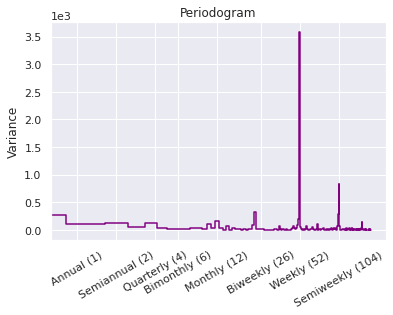

In [55]:
_ = plot_periodogram(final_df.loc['2015-01-01':'2017-08-15'].groupby(by='date').sales.mean())

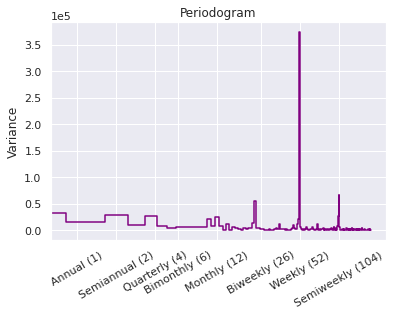

In [56]:
_ = plot_periodogram(final_df.query("family=='GROCERY I'").loc['2015-01-01':'2017-08-15'].groupby(by='date').sales.mean())

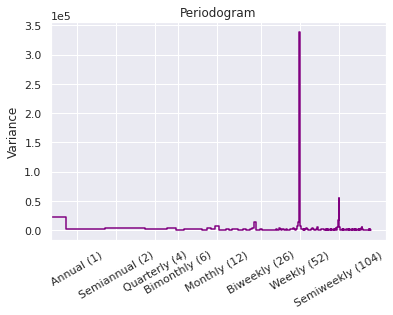

In [57]:
_ = plot_periodogram(final_df.query("family=='BEVERAGES'").loc['2015-01-01':'2017-08-15'].groupby(by='date').sales.mean())

In [58]:
final_df

,id,store_nbr,family,sales,onpromotion,city,state,store,cluster,uniquestore,...,isclosed,dcoilwtico,lagoil_1_dcoilwtico,lagoil_2_dcoilwtico,lagoil_3_dcoilwtico,lagoil_4_dcoilwtico,oil_week_avg,oil_month_avg,transactions,tot_store_day_onprom
date,,,,,,,,,,,,,,,,,,,,,
2016-06-01,2216808,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,0,...,0,49.07,49.10,49.165,49.23,49.295000,49.174286,47.024333,1898.0,363
2016-06-01,2216809,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,0,...,0,49.07,49.10,49.165,49.23,49.295000,49.174286,47.024333,1898.0,363
2016-06-01,2216810,1,BEAUTY,4.0,0,Quito,Pichincha,D,13,0,...,0,49.07,49.10,49.165,49.23,49.295000,49.174286,47.024333,1898.0,363
2016-06-01,2216811,1,BEVERAGES,2199.0,37,Quito,Pichincha,D,13,0,...,0,49.07,49.10,49.165,49.23,49.295000,49.174286,47.024333,1898.0,363
2016-06-01,2216812,1,BOOKS,0.0,0,Quito,Pichincha,D,13,0,...,0,49.07,49.10,49.165,49.23,49.295000,49.174286,47.024333,1898.0,363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,NaN,1,Quito,Pichincha,B,6,0,...,0,47.26,45.96,46.460,46.40,46.816667,46.825714,48.034333,None,223
2017-08-31,3029396,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,0,...,0,47.26,45.96,46.460,46.40,46.816667,46.825714,48.034333,None,223
2017-08-31,3029397,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,0,...,0,47.26,45.96,46.460,46.40,46.816667,46.825714,48.034333,None,223


In [67]:
# !gdown 1jhMnPnktsshZ2JyajPfWckgVj37xqyLZ

In [68]:
# final_df = pd.read_csv("datafinal.csv")
# final_df

In [59]:
def tags_to_dict():
    tags = {
     'AUTOMOTIVE': [4, 7, 30, 10, 'family'],
     'BABY CARE':  [-8, 2, 25, 5, 'family'],
     'BEAUTY': [-8, 7, 25, 5, 'other'],
     'BEVERAGES': [0, 0, 40, 40, 'food'],
     'BOOKS': [0, 0, 55, 15, 'other'],
     'BREAD/BAKERY': [-3, 0, 30, 30, 'food'],
     'CELEBRATION': [-5, 5, 50, 20, 'family'],
     'CLEANING': [-8, 3, 40, 20, 'food'],
     'DAIRY': [-4, 0, 40, 40, 'food'],
     'DELI': [3, 6, 40, 20, 'food'],
     'EGGS': [-4, -5, 40, 20, 'food'],
     'FROZEN FOODS': [-4, -3, 40, 20, 'food'],
     'GROCERY I': [-4, 3, 40, 20, 'food'],
     'GROCERY II': [-4, 3, 40, 20, 'food'],
     'HARDWARE': [10, 10, 30, 20, 'other'],
     'HOME AND KITCHEN I': [-10, 4, 40, 20, 'family'],
     'HOME AND KITCHEN II': [-10, 4, 40, 20, 'family'],
     'HOME APPLIANCES': [0, 4, 40, 20, 'family'],
     'HOME CARE': [-10, 4, 40, 20, 'family'],
     'LADIESWEAR': [-10, 4, 40, 20, 'other'],
     'LAWN AND GARDEN': [-10, 4, 40, 20, 'family'],
     'LINGERIE': [-10, 4, 40, 2, 'other'],
     'LIQUOR,WINE,BEER': [4, 8, 40, 20, 'food'],
     'MAGAZINES': [-6, -7, 50, 20, 'other'],
     'MEATS': [-4, 5, 40, 20, 'food'],
     'PERSONAL CARE': [-5, 5, 40, 20, 'family'],
     'PET SUPPLIES': [-5, 0, 40, 20, 'family'],
     'PLAYERS AND ELECTRONICS': [5, 5, 25, 10, 'other'],
     'POULTRY': [-7, -4, 40, 20, 'food'],
     'PREPARED FOODS': [0, 6, 30, 10, 'food'],
     'PRODUCE': [0, 0, 40, 40, 'other'],
     'SCHOOL AND OFFICE SUPPLIES': [3, 3, 25, 15, 'family'],
     'SEAFOOD': [-5, 8, 40, 20, 'food']
    }
    
    sex_dict = {}
    luxury_dict = {}
    age_mean_dict = {}
    age_var_dict = {}
    type_dict = {}
    for i in tags.keys():
        sex_dict[i] = tags[i][0]
        luxury_dict[i] = tags[i][1]
        age_mean_dict[i] = tags[i][2]
        age_var_dict[i] = tags[i][3]
        type_dict[i] = tags[i][4]
    return [sex_dict, luxury_dict, age_mean_dict, age_var_dict, type_dict]

In [60]:
sex_dict, luxury_dict, age_mean_dict, age_var_dict, type_dict = tags_to_dict()
final_df['tag_sex'] = final_df.family.map(sex_dict)
final_df['tag_luxury'] = final_df.family.map(luxury_dict)
final_df['tag_age_mean'] = final_df.family.map(age_mean_dict)
final_df['tag_age_var'] = final_df.family.map(age_var_dict)
final_df['tag_type'] = final_df.family.map(type_dict)
final_df = pd.get_dummies(final_df, columns=['tag_type'])
final_df

,id,store_nbr,family,sales,onpromotion,city,state,store,cluster,uniquestore,...,oil_month_avg,transactions,tot_store_day_onprom,tag_sex,tag_luxury,tag_age_mean,tag_age_var,tag_type_family,tag_type_food,tag_type_other
date,,,,,,,,,,,,,,,,,,,,,
2016-06-01,2216808,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,0,...,47.024333,1898.0,363,4,7,30,10,1,0,0
2016-06-01,2216809,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,0,...,47.024333,1898.0,363,-8,2,25,5,1,0,0
2016-06-01,2216810,1,BEAUTY,4.0,0,Quito,Pichincha,D,13,0,...,47.024333,1898.0,363,-8,7,25,5,0,0,1
2016-06-01,2216811,1,BEVERAGES,2199.0,37,Quito,Pichincha,D,13,0,...,47.024333,1898.0,363,0,0,40,40,0,1,0
2016-06-01,2216812,1,BOOKS,0.0,0,Quito,Pichincha,D,13,0,...,47.024333,1898.0,363,0,0,55,15,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,NaN,1,Quito,Pichincha,B,6,0,...,48.034333,None,223,-7,-4,40,20,0,1,0
2017-08-31,3029396,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,0,...,48.034333,None,223,0,6,30,10,0,1,0
2017-08-31,3029397,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,0,...,48.034333,None,223,0,0,40,40,0,0,1


In [61]:
final_df.isnull().sum()

id                          0
store_nbr                   0
family                      0
sales                   28512
onpromotion                 0
city                        0
state                       0
store                       0
cluster                     0
uniquestore                 0
newstore                    0
firstday                    0
event_type                  0
isevent                     0
isclosed                    0
dcoilwtico                  0
lagoil_1_dcoilwtico         0
lagoil_2_dcoilwtico         0
lagoil_3_dcoilwtico         0
lagoil_4_dcoilwtico         0
oil_week_avg                0
oil_month_avg               0
transactions            28512
tot_store_day_onprom        0
tag_sex                     0
tag_luxury                  0
tag_age_mean                0
tag_age_var                 0
tag_type_family             0
tag_type_food               0
tag_type_other              0
dtype: int64

# The model

In [62]:
def split_func (orig_df, X, y, end_date, test_size):
    
    # Splitting train and test
    idx_train, idx_test = train_test_split(orig_df.index, test_size=test_size, shuffle=False)
    X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
    y_train, y_test = y.loc[idx_train], y.loc[idx_test]
    
    return X_train, y_train, X_test, y_test

In [63]:
def add_features (orig_df):
    
    df = orig_df.copy()
        
    # Time features
    df['year'] = df.index.year.astype('int')
    df['quarter'] = df.index.quarter.astype('int')
    df['month'] = df.index.month.astype('int')
    df['day'] = df.index.day.astype('int')
    df['dayofweek'] = df.index.day_of_week.astype('int')
    df['weekofyear'] = df.index.week.astype('int')
    df['isweekend'] = df.dayofweek.apply(lambda x: 1 if x in (5,6) else 0)
    df['startschool'] = df.month.apply(lambda x: 1 if x in (4,5,8,9) else 0)
    
    df['daysinmonth'] = df.index.days_in_month.astype('int')

    # Dummy features
    df = pd.get_dummies(df, columns=['year'], drop_first=True)
    df = pd.get_dummies(df, columns=['quarter'], drop_first=True)
    df = pd.get_dummies(df, columns=['dayofweek'], drop_first=True)
    df = pd.get_dummies(df, columns=['store'], drop_first=True)
    df = pd.get_dummies(df, columns=['event_type'], drop_first=True)
    df = pd.get_dummies(df, columns=['isevent'], drop_first=True)
    df = pd.get_dummies(df, columns=['state'], drop_first=True)

    # DeterministicProcess
    fourierA = CalendarFourier(freq='A', order=5)
    fourierM = CalendarFourier(freq='M', order=2)
    fourierW = CalendarFourier(freq='W', order=4)

    dp = DeterministicProcess(index=df.index,
                          order=1,
                          seasonal=False,
                          constant=False,
                          additional_terms=[fourierA, fourierM, fourierW],
                          drop=True)
    dp_df = dp.in_sample()
    df = pd.concat([df, dp_df], axis=1)
    
    # Outliers
    df['outliers'] = df.sales.apply(lambda x: 1 if x>30000 else 0)
    
    df.drop(columns=['daysinmonth', 'month', 'city'], inplace=True)
    
    return df

In [77]:
def model_func (orig_df, end_df, n):
    
    df = add_features(orig_df).loc[:end_df,:].reset_index().set_index(['store_nbr', 'family', 'date']).sort_index()
    y = np.log1p(df.loc[:,'sales'].unstack(['store_nbr', 'family']))
    
    # Selecting features
    cols = df.columns[df.columns.str.match(r'year|quarter|event|isevent|isclosed|oil|dcoilwtico|tag_sex|tag_luxury|tag_age_mean|tag_age_var|tag_type|week|isweek|startschool|sin|cos|trend')]
    X = df.loc[:,cols]
    X = X.groupby(by='date').first()
    
    X_tr, y_tr, X_te, y_te = split_func(y, X, y, end_df, n)
    # Train
    if end_df <= date['date_end_train']:
        y_tr = np.empty((diff_train-n,0))
        y_te = np.empty((n,0))
        pred_train_y = np.empty((diff_train-n,0))
        pred_test_y = np.empty((n,0))
    # Test
    else:
        y_tr = np.empty((diff_test-n,0))
        y_te = np.empty((n,0))
        pred_train_y = np.empty((diff_test-n,0))
        pred_test_y = np.empty((n,0))
    
    # A model for each shop
    for i in orig_df.store_nbr.unique():
        y = df.loc[i,'sales'].unstack(['family'])
        X = df.loc[i,cols]
        X = X.groupby(by='date').first()

        # Splitting train and test and log transformation
        X_train, y_train, X_test, y_test = split_func(y, X, np.log1p(y), end_df, n)
                
        # Exponentially weighted cost function
        weights = X_train.year_2017.apply(lambda x: np.exp((-0.9)*1) if x == 0 else np.exp((-0.9)*0)) 
        
        # Linear regression
        model = LinearRegression()
        model.fit(X_train, y_train, sample_weight=weights)
        lr_pred_train_y = model.predict(X_train) 
        lr_pred_test_y = model.predict(X_test)
        
        # Random Forest
        model = RandomForestRegressor(n_estimators=320, random_state=0)
        model.fit(X_train, y_train, sample_weight=weights)
        rf_pred_train_y = model.predict(X_train) 
        rf_pred_test_y = model.predict(X_test)
        
        # Average result
        # st_pred_train_y = lr_pred_train_y * 0.5 + rf_pred_train_y * 0.5
        # st_pred_test_y = lr_pred_test_y * 0.5 + rf_pred_test_y * 0.5
        
        st_pred_train_y = lr_pred_train_y * 0 + rf_pred_train_y * 1
        st_pred_test_y = lr_pred_test_y * 0 + rf_pred_test_y * 1

        y_tr = np.append(y_tr, y_train, axis=1)
        y_te = np.append(y_te, y_test, axis=1)
        pred_train_y = np.append(pred_train_y, st_pred_train_y, axis=1)
        pred_test_y = np.append(pred_test_y, st_pred_test_y, axis=1)
        
        # Performances of each shop
        # Train
        if end_df <= date['date_end_train']:
            print(f'RMSLE_train st_n {i}: ', np.round(np.sqrt(mean_squared_error(y_train.clip(0.0), st_pred_train_y.clip(0.0))), 4), f'RMSLE_test st_n {i}: ', np.round(np.sqrt(mean_squared_error(y_test.clip(0.0), st_pred_test_y.clip(0.0))), 4))
        # Test
        else:
            print(f'RMSLE_train st_n {i}: ', np.round(np.sqrt(mean_squared_error(y_train.clip(0.0), st_pred_train_y.clip(0.0))), 4))
        
    iterables = [final_df.store_nbr.unique(), final_df.family.sort_values().unique()]
    index = pd.MultiIndex.from_product(iterables, names=['store_nbr', 'family'])
    
    y_tr = pd.DataFrame(y_tr, columns=index, index=X_tr.index)
    y_te = pd.DataFrame(y_te, columns=index, index=X_te.index)
    pred_train_y = pd.DataFrame(pred_train_y, columns=y_tr.columns, index=y_tr.index)
    pred_test_y = pd.DataFrame(pred_test_y, columns=y_te.columns, index=y_te.index)
    
    # Total performances
    # Train
    if end_df <= date['date_end_train']:
        print(f'RMSLE_train tot: ', np.round(np.sqrt(mean_squared_error(y_tr.clip(0.0), pred_train_y.clip(0.0))), 4), f'RMSLE_test tot: ', np.round(np.sqrt(mean_squared_error(y_te.clip(0.0), pred_test_y.clip(0.0))), 4))
    # Test
    else:
        print(f'RMSLE_train tot: ', np.round(np.sqrt(mean_squared_error(y_tr.clip(0.0), pred_train_y.clip(0.0))), 4)) 
   
    y_tr = y_tr.stack(['store_nbr', 'family'])
    y_te = y_te.stack(['store_nbr', 'family'])
    y = pd.concat([y_tr, y_te])
    
    pred_train_y = pred_train_y.stack(['store_nbr', 'family'])
    pred_test_y = pred_test_y.stack(['store_nbr', 'family'])
    # If sales < 0 -> 0
    pred_y = pd.concat([pd.Series(pred_train_y).apply(lambda x: 0 if x<0 else x), pd.Series(pred_test_y).apply(lambda x: 0 if x<0 else x)])
    
    # Train
    if end_df <= date['date_end_train']:

        # Some plots to check 
        fig, axes = plt.subplots(4, 2, figsize=(15,10))
        y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum().plot(ax=axes[0,0], color="red")
        pred_y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum().plot(ax=axes[0,0], color="orange")
    
        y.loc['2017-08':,:].reset_index().groupby(by='date')[0].sum().plot(ax=axes[0,1], color="red")
        pred_y.loc['2017-08':,:].reset_index().groupby(by='date')[0].sum().plot(ax=axes[0,1], color="orange")
    
        y.loc['2017-02':,:].reset_index().query("family=='GROCERY I'").groupby(by='date')[0].sum().plot(ax=axes[1,0], color="red")
        pred_y.loc['2017-02':,:].reset_index().query("family=='GROCERY I'").groupby(by='date')[0].sum().plot(ax=axes[1,0], color="orange")
    
        y.loc['2017-02':,:].reset_index().query("family=='SCHOOL AND OFFICE SUPPLIES'").groupby(by='date')[0].sum().plot(ax=axes[1,1], color="red")
        pred_y.loc['2017-02':,:].reset_index().query("family=='SCHOOL AND OFFICE SUPPLIES'").groupby(by='date')[0].sum().plot(ax=axes[1,1], color="orange")
    
        (y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum() - pred_y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum()).plot(ax=axes[2,1])
        sns.residplot(ax=axes[2,0], x=pred_y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum(), y=zscore(y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum() - pred_y.loc['2017-02':,:].reset_index().groupby(by='date')[0].sum()), lowess=True, scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
        y.loc['2017-02':,:].reset_index().query("store_nbr==50").groupby(by='date')[0].sum().plot(ax=axes[3,0], color="red")
        pred_y.loc['2017-02':,:].reset_index().query("store_nbr==50").groupby(by='date')[0].sum().plot(ax=axes[3,0], color="orange")
    
        y.loc['2017-02':,:].reset_index().query("store_nbr==47").groupby(by='date')[0].sum().plot(ax=axes[3,1], color="red")
        pred_y.loc['2017-02':,:].reset_index().query("store_nbr==47").groupby(by='date')[0].sum().plot(ax=axes[3,1], color="orange")
        
        fig.tight_layout()
    # Test
    else:
        return pred_test_y, pred_y, y, df

In [78]:
model_pred_test_y, model_pred_tot_y, orig_y, final_df = model_func(final_df, date['date_end_test'], 16)

RMSLE_train st_n 1:  0.2465
RMSLE_train st_n 10:  0.2737
RMSLE_train st_n 11:  0.2648
RMSLE_train st_n 12:  0.2658
RMSLE_train st_n 13:  0.2806
RMSLE_train st_n 14:  0.2661
RMSLE_train st_n 15:  0.2715
RMSLE_train st_n 16:  0.2678
RMSLE_train st_n 17:  0.2559
RMSLE_train st_n 18:  0.2372
RMSLE_train st_n 19:  0.2802
RMSLE_train st_n 2:  0.2347
RMSLE_train st_n 20:  0.2725
RMSLE_train st_n 21:  0.2771
RMSLE_train st_n 22:  0.2704
RMSLE_train st_n 23:  0.2573
RMSLE_train st_n 24:  0.2336
RMSLE_train st_n 25:  0.265
RMSLE_train st_n 26:  0.2963
RMSLE_train st_n 27:  0.2468
RMSLE_train st_n 28:  0.2726
RMSLE_train st_n 29:  0.2644
RMSLE_train st_n 3:  0.2141
RMSLE_train st_n 30:  0.281
RMSLE_train st_n 31:  0.2759
RMSLE_train st_n 32:  0.2841
RMSLE_train st_n 33:  0.2734
RMSLE_train st_n 34:  0.2742
RMSLE_train st_n 35:  0.2697
RMSLE_train st_n 36:  0.2779
RMSLE_train st_n 37:  0.239
RMSLE_train st_n 38:  0.2436
RMSLE_train st_n 39:  0.2702
RMSLE_train st_n 4:  0.2392
RMSLE_train st_n 40: 

# Final result

In [79]:
y = pd.Series(np.exp(model_pred_tot_y.values) - 1, index=model_pred_tot_y.index)

In [80]:
sub = final_df.reset_index().set_index(['date', 'store_nbr', 'family']).sort_index().loc[date['date_start_fore']:, 'id']

In [81]:
fin_sub = pd.concat([sub, y], axis=1)

In [82]:
fin_sub = fin_sub.rename(columns={0:'sales'})

In [83]:
fin_sub['sales'] = fin_sub['sales'].apply(lambda x: 0 if x<0 else x) 

In [84]:
fin_sub = fin_sub.loc['2017-08-16':]

In [85]:
fin_sub

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     3.493741
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     4.036023
                     BEVERAGES                   3000891  2318.632267
                     BOOKS                       3000892     0.269764
...                                                  ...          ...
2017-08-31 54        POULTRY                     3029263    52.596668
                     PREPARED FOODS              3029264    79.243582
                     PRODUCE                     3029265   537.247465
                     SCHOOL AND OFFICE SUPPLIES  3029266     0.101681
                     SEAFOOD                     3029267     1.452869

[28512 rows x 2 columns]

# Submission

In [86]:
fin_sub.to_csv('submission.csv', index=False)